In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

sns.set_style("whitegrid")
sns.despine()

<Figure size 640x480 with 0 Axes>

In [ ]:
df = pd.read_csv("insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# Exploring The Dataset

In [ ]:
df.corr()["charges"]

age         0.299008
bmi         0.198341
children    0.067998
charges     1.000000
Name: charges, dtype: float64

array([[<AxesSubplot:title={'center':'charges'}>]], dtype=object)

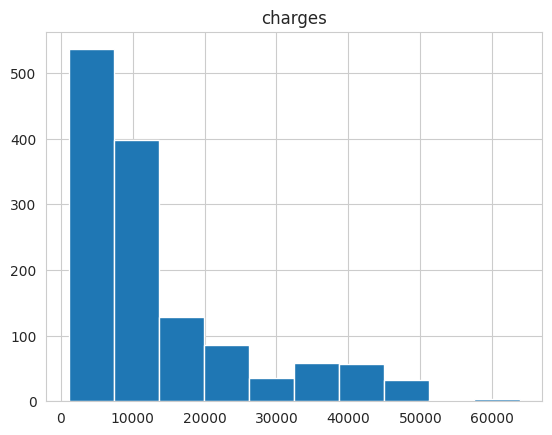

In [ ]:
df.hist("charges")

=> Cột "charges" có phân phối lệch phải. Các khoản phí bảo hiểm cực kỳ đắt đỏ thường xuất hiện nhiều hơn so với các khoản phí nhỏ hơn. Điều này làm cho việc sai số trong mô hình không thể thực sự tập trung ở giá trị zero. Có thể xem xét thực hiện biến đổi log cho kết quả.

Khi chúng ta vẽ biểu đồ histogram, các cột cao tại khoảng giá trị 10,000 và 20,000 thực sự là tần suất của các khoản chi phí nằm trong khoảng đó. Điều này không phản ánh tỷ lệ số lượng khoản chi phí đắt đỏ so với khoản chi phí rẻ.

**Tại sao lại như vậy?**
- Có một số khoản chi phí đắt đỏ (ví dụ: các khoản chi phí y tế lớn) xuất hiện rất hiếm khi, nhưng khi xuất hiện, chúng có giá trị lớn.
- Trong khi đó, các khoản chi phí rẻ hơn (ví dụ: các khoản chi phí nhỏ hơn) xuất hiện thường xuyên hơn, nhưng giá trị của chúng thấp hơn.

Vì vậy, mặc dù tần suất của các khoản chi phí đắt đỏ thấp hơn, giá trị của chúng khiến chúng trở nên quan trọng hơn trong phân tích. Điều này dẫn đến sự lệch phải trong phân phối.

array([[<AxesSubplot:title={'center':'log_charges'}>]], dtype=object)

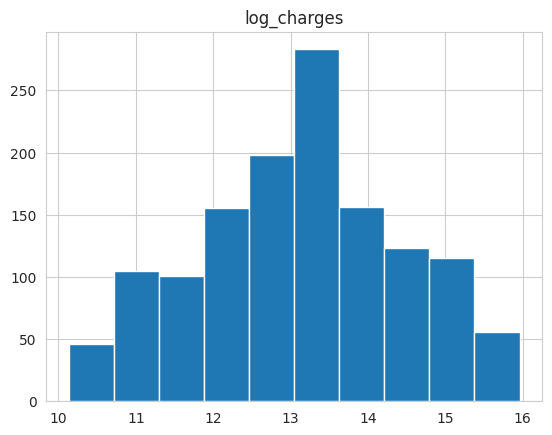

In [ ]:
df["log_charges"] = np.log2(df["charges"])

df.hist("log_charges")

=> Cột giá trị `charges` sau khi áp dụng hàm log được phân bố gần trung tâm hơn, đúng như mong muốn. Điều này làm cho khả năng sai số của mô hình không bị thiên lệch.

In [ ]:
df.corr()["log_charges"]

age            0.527834
bmi            0.132669
children       0.161336
charges        0.892964
log_charges    1.000000
Name: log_charges, dtype: float64

In [ ]:
df.corr()

,age,bmi,children,charges,log_charges
age,1.000000,0.109272,0.042469,0.299008,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.892964
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000


# Dividing The Data

In [ ]:
df["is_smoker"] = df["smoker"].apply(lambda x: 1 if x == "yes" else 0)
X = df[["age", "bmi", "is_smoker"]]
y = df["log_charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 47)

# Build The Model

In [ ]:
model = LinearRegression()

model.fit(X_train, y_train)
predicts = model.predict(X_train)

r2_score(y_train, predicts)

0.7388489389288027

In [ ]:
mean_squared_error(y_train, predicts)

0.4509520661460599

In [ ]:
np.exp(mean_squared_error(y_train, predicts))

1.5698060334366168

=> Tỷ lệ sai số bình phương trung bình (MSE) của mô hình trên tập huấn luyện là 0.45 và trên tỷ lệ gốc là 1.56. Giá trị R-squared cho thấy mô hình có thể giải thích 73% biến thiên trong log của chi phí bảo hiểm. Tuy kết quả ban đầu khá tích cực, nhưng chúng ta cần nhớ rằng đây là các giá trị lạc quan. 😊

# Residual Diagnostics

In [ ]:
residual = y_train - predicts

Text(0, 0.5, 'residual')

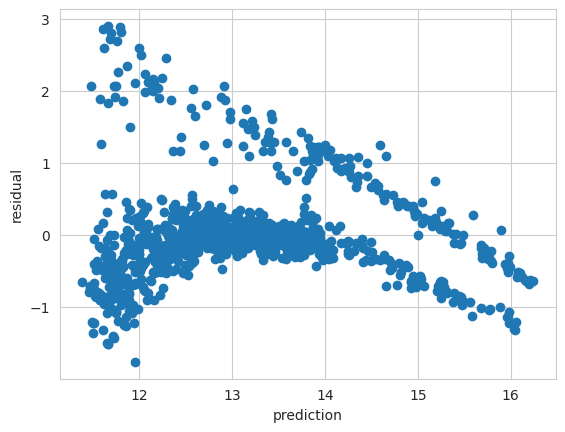

In [ ]:
plt.scatter(predicts, residual)
plt.xlabel("prediction")
plt.ylabel("residual")

1. **Phân phối của phần dư**:
   - Nếu các giá trị phần dư không xoay quanh số 0 và có một mẫu rõ rệt, điều này cho thấy mô hình hồi quy tuyến tính có thể không phù hợp với dữ liệu.
   - Có thể có các yếu tố khác không được mô hình hóa hoặc mối quan hệ không phải tuyến tính.

2. **Khả năng tổng quát hóa**:
   - Mô hình hồi quy tuyến tính nên có khả năng tổng quát hóa tốt trên dữ liệu mới (tập kiểm tra).
   - Nếu phần dư không ngẫu nhiên và có mẫu, mô hình có thể không tổng quát hóa tốt.

3. **Kiểm tra thêm**:
   - Để đánh giá chính xác, chúng ta nên kiểm tra các độ đo khác như R-squared, sai số dự đoán trên tập kiểm tra, và kiểm tra giả thuyết về phân phối của phần dư.


# Interpreting The Model

In [ ]:
inter = model.intercept_
inter

10.233481408281971

In [ ]:
coef = model.coef_
coef

array([0.05054496, 0.01513969, 2.21581421])

1. **Tăng 1 năm về tuổi (subject)**:
   - Tăng 1 năm về tuổi được liên kết với việc tăng trung bình 0.05 trong log của chi phí bảo hiểm, khi giữ nguyên trạng thái hút thuốc và chỉ số BMI. Tương đương với tăng khoảng 5% trong chi phí trên tỷ lệ gốc.

2. **Tăng 1 đơn vị về chỉ số BMI (subject)**:
   - Tăng 1 đơn vị về chỉ số BMI được liên kết với việc tăng trung bình 0.015 trong log của chi phí bảo hiểm, khi giữ nguyên trạng thái hút thuốc và tuổi. Tương đương với tăng khoảng 1.5% trong chi phí trên tỷ lệ gốc.

3. **Trạng thái hút thuốc (smoker)**:
   - Người hút thuốc được liên kết với việc tăng trung bình 2.21 trong log của chi phí bảo hiểm, khi giữ nguyên tuổi và chỉ số BMI. Tương đương với tăng khoảng 811% trong chi phí trên tỷ lệ gốc.

In [ ]:
pct_1, pct_2, pct_3  = (np.exp(0.05) - 1) * 100, (np.exp(0.015) - 1) * 100, (np.exp(2.21) - 1) * 100
pct_1, pct_2, pct_3

(5.127109637602412, 1.511306461571893, 811.5716393040306)

# Final Model Evaluation

In [ ]:
y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred)

0.4424024810708572

In [ ]:
r2_score(y_test, y_pred)

0.7647392671726335

In [ ]:
np.exp(mean_squared_error(y_test, y_pred))

1.5564420528503653

=> Dự đoán sai số trung bình (MSE) trên tập kiểm tra là khoảng 0.44, trong khi MSE trên tập huấn luyện là khoảng 0.45. Trong trường hợp này, hai sai số khá phù hợp với nhau, vì vậy chúng ta có thể kết luận rằng mô hình không bị quá khớp (overfit). **Tuy nhiên, các giá trị dư thừa (residuals) cho thấy mô hình dự đoán chi phí thấp hơn đối với các đối tượng thực tế đã bị tính phí cao hơn. Do đó, mô hình gặp khó khăn trong việc dự đoán các chi phí cao hơn.** Tổng thể, dự đoán của mô hình quá thận trọng.

Chúng ta có thể cải thiện mô hình bằng cách bao gồm các thuật ngữ phức tạp hơn trong hồi quy, chẳng hạn như tương tác hoặc thuật ngữ bậc hai.


----------------------------------------------------------------------------------------------------------------

Trước tiên, chúng ta cần nhớ lại mục tiêu của mô hình hồi quy tuyến tính: dự đoán biến phụ thuộc (trong trường hợp này là chi phí) dựa trên các biến độc lập (tuổi, BMI và thông tin về việc hút thuốc).

1. **Giá trị dư thừa (residuals)**:
   - Giá trị dư thừa là sự khác biệt giữa giá trị thực tế của biến phụ thuộc và giá trị được dự đoán bởi mô hình.
   - Trong trường hợp của bạn, nếu mô hình dự đoán chi phí thấp hơn so với giá trị thực tế (các đối tượng đã bị tính phí cao hơn), thì giá trị dư thừa sẽ là dương.
   - Điều này có nghĩa là mô hình của bạn "thận trọng" hơn trong việc dự đoán chi phí. Nó cố gắng tránh dự đoán quá cao để không làm sai lệch kết quả.

2. **Mô hình gặp khó khăn với các chi phí cao hơn**:
   - Khi mô hình gặp khó khăn trong việc dự đoán các chi phí cao hơn, điều này có thể do nhiều nguyên nhân:
     - **Khả năng biểu diễn**: Mô hình có thể không đủ phức tạp để biểu diễn đúng mối quan hệ giữa các biến. Có thể cần thêm các thuật ngữ phức tạp hơn (tương tác, thuật ngữ bậc hai) để cải thiện mô hình.
     - **Dữ liệu**: Dữ liệu huấn luyện có thể không đủ để mô hình học được mối quan hệ cho các chi phí cao hơn.
     - **Biến khác**: Có thể có các biến khác mà mô hình chưa xem xét (ví dụ: loại bệnh, vị trí, v.v.).

3. **Cách cải thiện mô hình**:
   - Bạn có thể thử bổ sung thêm các biến khác hoặc thay đổi cấu trúc mô hình (ví dụ: sử dụng mô hình tuyến tính hỗn hợp, mô hình phi tuyến, hoặc mô hình hồi quy Ridge/Lasso).
   - Kiểm tra lại dữ liệu và xem xét việc thu thập thêm thông tin về các đối tượng có chi phí cao hơn.